In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import SVD, SVDpp, NMF
from surprise import SlopeOne, CoClustering

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


In [2]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


In [3]:
display(rating.describe())

,userId,productId,rating
count,7.202839e+06,7.202921e+06,7.202920e+06
mean,3.368837e+05,2.651382e+05,4.277313e+00
std,3.619076e+05,1.525959e+05,1.060728e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331870e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965950e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


In [4]:
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [5]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

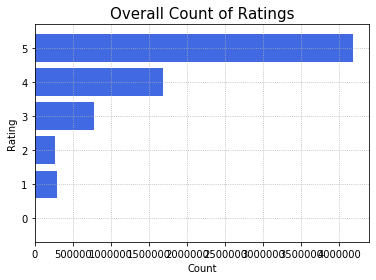

,rating,Count
0,0.0,1
1,1.0,293748
2,2.0,261960
3,3.0,781982
4,4.0,1680574


In [6]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()
display(ratingViaUserCount.head())

In [8]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 50 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 100 ].index)]
print(ratingFiltered.shape)

(1847803, 3)
(7202921, 3)
(35024, 3)


In [9]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratingFiltered[['userId', 'productId', 'rating']], reader)

In [10]:
display(products.sample(10))
display(ratingFiltered.sample(10))
display(ratingFiltered.shape)

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
150642,媒介经营与管理,"832,723,189",832,图书音像,723,人文社科类图书,189.0,社会科学
420835,The Gormenghast Trilogy,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
369950,商品流通企业财务管理,"832,151,211",832,图书音像,151,经管类图书,211.0,管理
437220,施工方案范例50篇(第2版)(附盘),"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试
106465,超级趣味日语,"832,1101,921",832,图书音像,1101,少儿/教育图书,921.0,外语
13725,利其尔PPSU吸管型哺乳瓶用配件吸管(2套装)N,"911,793,896",911,母婴/玩具,793,喂养用品,896.0,餐具/饮具/研磨
184580,美学原理新编,"832,723,396",832,图书音像,723,人文社科类图书,396.0,哲学/宗教
408929,军事科学院硕士研究生系列教材(第2版):联合战役指挥教程,"832,723,221",832,图书音像,723,人文社科类图书,221.0,政治/军事
96681,远大前程,"832,519,1",832,图书音像,519,文学艺术,1.0,小说


,userId,productId,rating
361618,4962.0,236870,5.0
1284803,2457.0,26741,5.0
3634470,104283.0,514838,5.0
3745596,65563.0,284259,4.0
6691052,15596.0,404381,4.0
4140359,65650.0,32572,5.0
2977950,3204.0,164032,5.0
1606713,56399.0,221126,5.0
732294,64771.0,375187,4.0
6783366,40567.0,410321,5.0


(35024, 3)

In [11]:
print('No. of Unique Users    :', ratingFiltered.userId.nunique())
print('No. of Unique Products :', ratingFiltered.productId.nunique())
print('No. of Unique Ratings  :', ratingFiltered.rating.nunique())
print(products.iloc[1].product_name)

No. of Unique Users    : 241
No. of Unique Products : 22683
No. of Unique Ratings  : 5
Treasure Island


In [24]:
productJoinEdRaiting = pd.merge(products, ratingFiltered, on='productId', how='inner')

In [25]:
display(productJoinEdRaiting.sample(10))

,productId,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name,userId,rating
31198,469599,写给大家看的设计书(第3版),"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿,858.0,5.0
6126,91826,"孩子,把你的手给我","832,665,45",832,图书音像,665,生活类图书,45.0,亲子/家教,858.0,3.0
26605,402182,Kingston 金士顿 Class4 16G TF卡(micro SD)手机存储卡,"1057,268,902",1057,电脑/办公,268,存储设备,902.0,存储卡,29792.0,5.0
3758,54518,水浒全传,"832,519,1",832,图书音像,519,文学艺术,1.0,小说,7811.0,5.0
31785,478602,HTC New One 801e WCDMA/GSM 3G手机(魅夜红 联通定制) 4.7英...,"1057,205,642",1057,电脑/办公,205,电脑整机,642.0,平板电脑,30058.0,5.0
3358,47898,星火英语·6级真题试卷(2014.6)新题型真题详解+标准预测6级(10套真题+5套预测试卷...,"832,1101,1116",832,图书音像,1101,少儿/教育图书,1116.0,考试,155593.0,3.0
17205,263509,UNIX环境高级编程(第2版),"832,1096,43",832,图书音像,1096,科技类图书,43.0,计算机/网络,39458.0,3.0
33044,495342,Edifier漫步者 R301T北美版 2.1声道音箱(黑色 金属网面 超薄音箱),"1057,439,1064",1057,电脑/办公,439,外设产品,1064.0,电脑音箱,9560.0,4.0
24092,371144,Netcore 磊科 300M高覆盖 全高清无线路由器NW714,"1057,390,815",1057,电脑/办公,390,网络设备,815.0,路由器/中继器,119.0,4.0
28051,425285,范梦泽 宫廷蚊帐 玫瑰方帐 三明治防蚊布 方顶三开门 不锈钢支架 落地蚊帐 适合1.8米床 ...,"933,229,596",933,家居生活,229,窗帘/布艺/地毯,596.0,蚊帐/床幔,139060.0,4.0


In [12]:
from collections import defaultdict

from surprise import SVD
from surprise import Dataset


def get_top_n(predictions, n=10):
    # 首先将预测值映射至每个用户
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
data = Dataset.load_builtin('ml-100k')
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
finish to fit the dataset...
The size is (35024, 3)
Finish to map the productId to innerId
Recommen for the product Vinda维达蓝色经典至有份量卫生卷纸(200g*10卷) ( 家居生活 | 生活日用 | 餐巾纸/卫生纸/湿巾 ) 

The 10 nearest neighbors of Toy Story are:
致我们终将逝去的青春(附"致青春"珍藏卡册) ( 图书音像 | 文学艺术 | 青春文学 ) 
拆掉思维里的墙:原来我还可以这样活(俞敏洪徐小平张德芬推崇的人生开窍手册) ( 图书音像 | 人文社科类图书 | 哲学/宗教 ) 
易简防水理发器(陶瓷头)HK668 机身图案随机 ( 母婴/玩具 | 婴儿洗护 | 清洁用品 ) 
新东方????永不言败 ( 图书音像 | 经管类图书 | 成功/励志 ) 
看得开,放得下,才是人生(随机附精美书签1张) ( 图书音像 | 文学艺术 | 青春文学 ) 
新东方????永不言败 ( 图书音像 | 少儿/教育图书 | 少儿 ) 
心 ( 图书音像 | 文学艺术 | 小说 ) 
文化苦旅 ( 图书音像 | 人文社科类图书 | 文化 ) 
空间大师三格储物柜BZ4386 ( 家具/家装/建材 | 家具 | 柜类 ) 
TP-LINK TL-WR740N 11N 150M无线路由器 ( 电脑/办公 | 网络设备 | 路由器/中继器 ) 


In [26]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

Recommen for the product UNIX环境高级编程(第2版) ( 图书音像 | 科技类图书 | 计算机/网络 ) 
The productInnerId is 17471

The 10 nearest neighbors of Toy Story are:
女子生活圣经 ( 图书音像 | 经管类图书 | 成功/励志 ) 
Jane Eyre (Barnes & Noble Classics Series) ( 图书音像 | 其它图书 | 进口图书 ) 
Alice's Adventures in Wonderland and Through the Looking Glass (Barnes & Noble Classics Series) ( 图书音像 | 其它图书 | 进口图书 ) 
The China Study: The Most Comprehensive Study of Nutrition Ever Conducted and the Startling Implications for Diet, Weight Loss and Long-term Health ( 图书音像 | 其它图书 | 进口图书 ) 
万水千山走遍 ( 图书音像 | 文学艺术 | 文学类 ) 
解读金融:成为金融高手的惟一途径 ( 图书音像 | 经管类图书 | 投资理财 ) 
笨狼和他的爸爸妈妈 ( 图书音像 | 少儿/教育图书 | 少儿 ) 
张信哲:逃生(2CD+DVD 加强版) ( 图书音像 | 音像 | 华语流行 ) 
钢笔书法自学速成:行楷每天30分种 ( 图书音像 | 文学艺术 | 艺术 ) 
桥文化 ( 图书音像 | 人文社科类图书 | 政治/军事 ) 
